In [3]:
#  https://www.kaggle.com/code/mannarmohamedsayed/colon-cancer-classification-cnn

Found 10000 files belonging to 2 classes.
(32, 180, 180, 3)
[1 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 1 1 0 1 0 1 1 0 0 0 0 1 1 1 0 1]
250
31
31
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 180, 180, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 180, 180, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 90, 90, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 90, 90, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 45, 45, 64)         0         
 2D)                                              

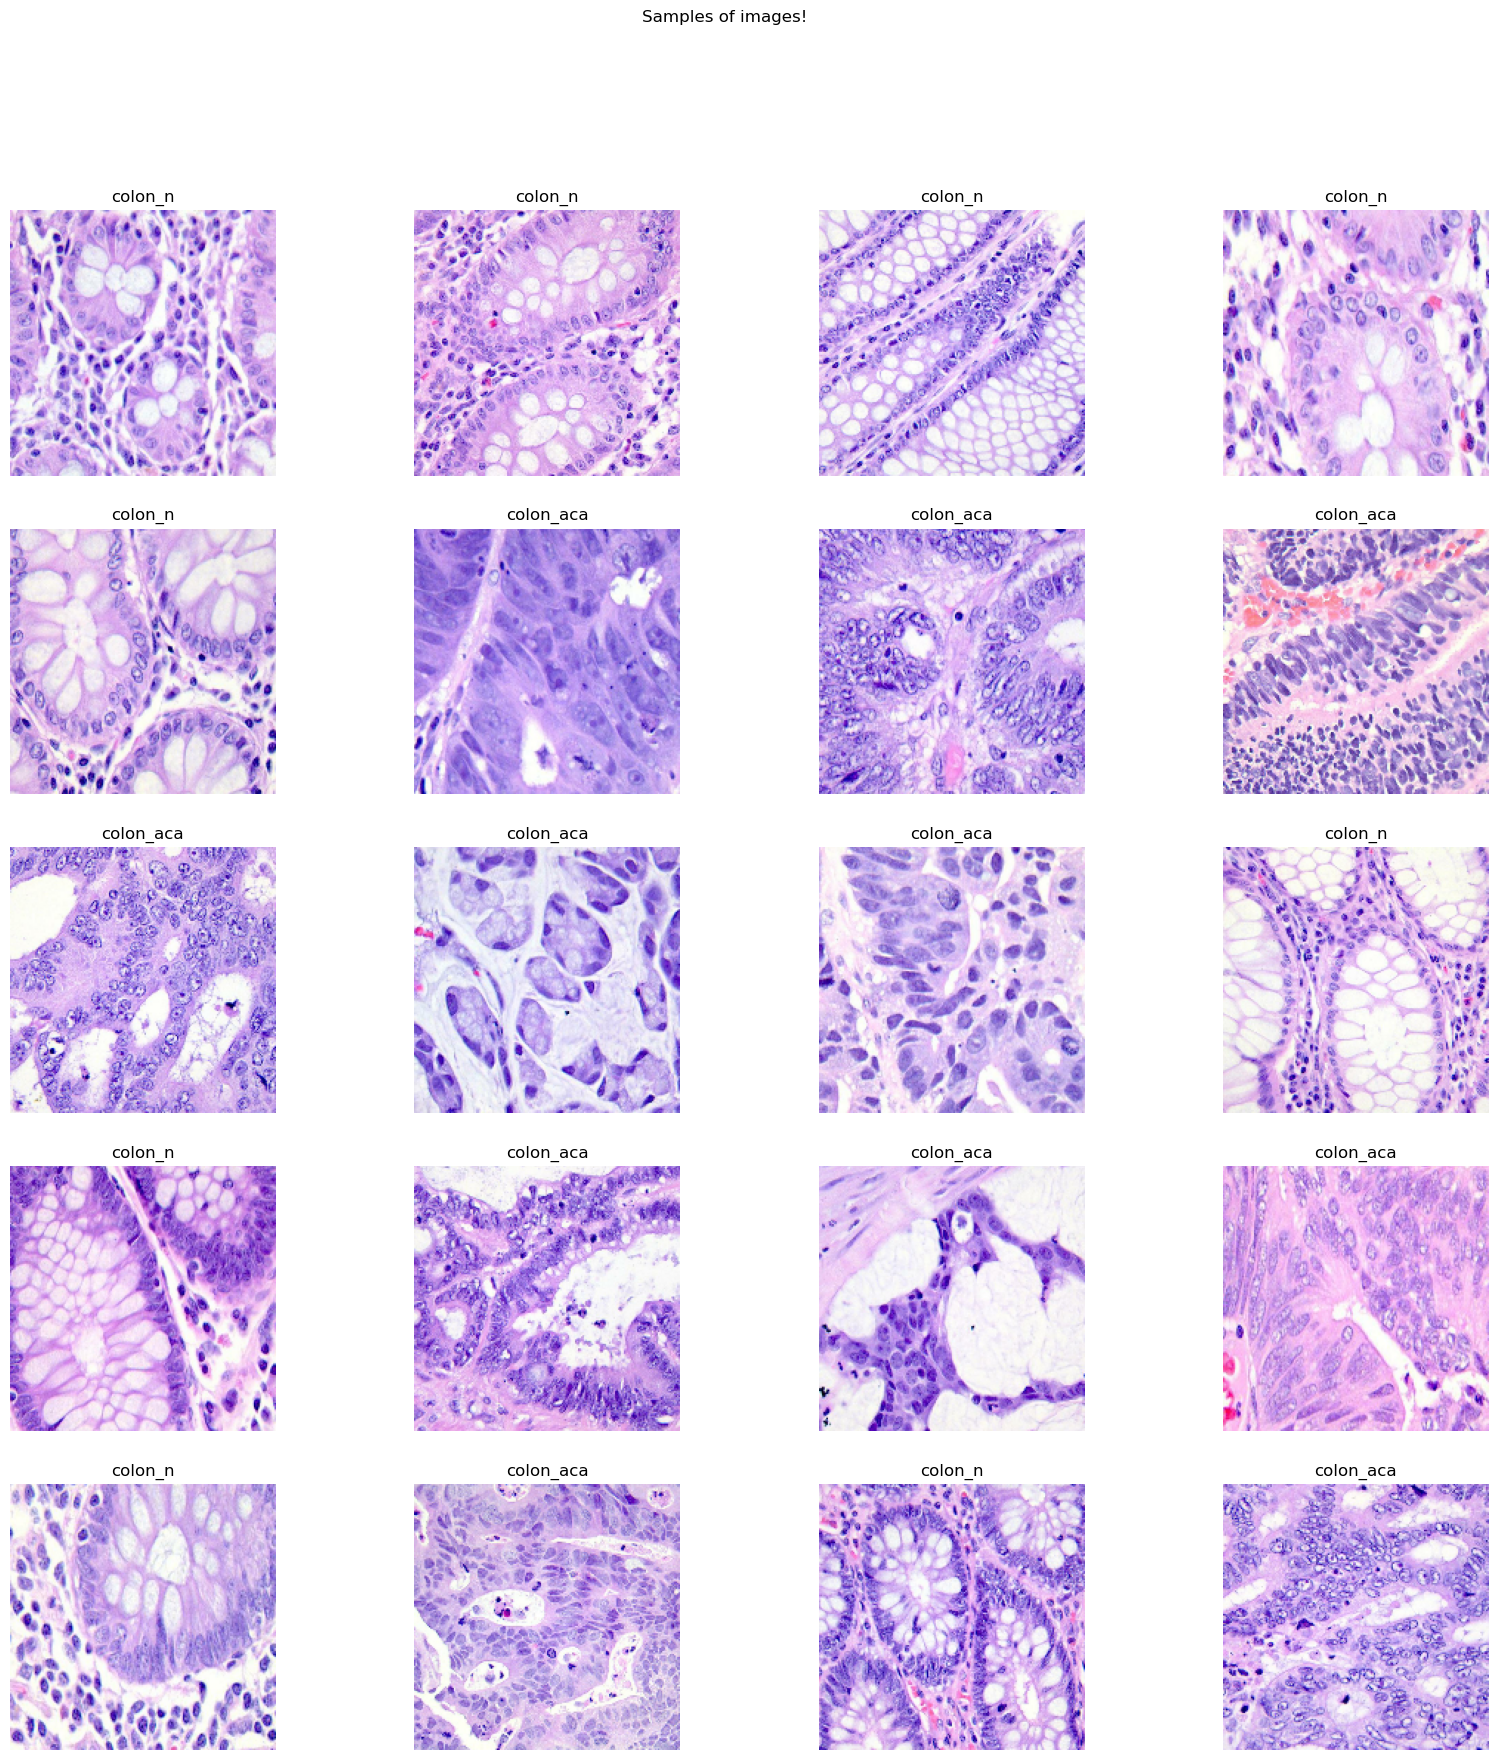

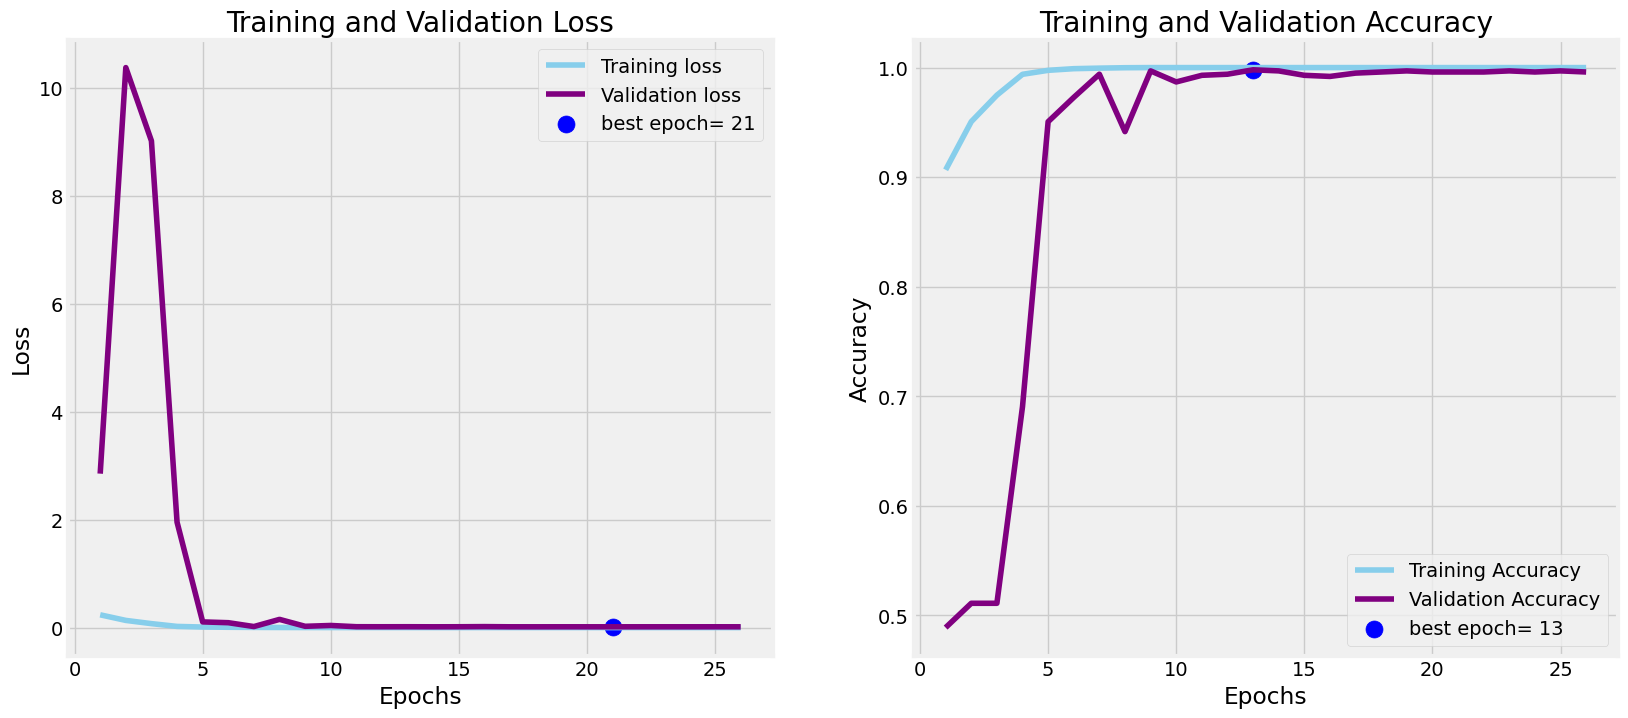

1/1 [==============================] - 0s 36ms/step
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       526
           1       0.99      1.00      1.00       466

    accuracy                           1.00       992
   macro avg       1.00      1.00      1.00       992
weighted avg       1.00      1.00      1.00       992



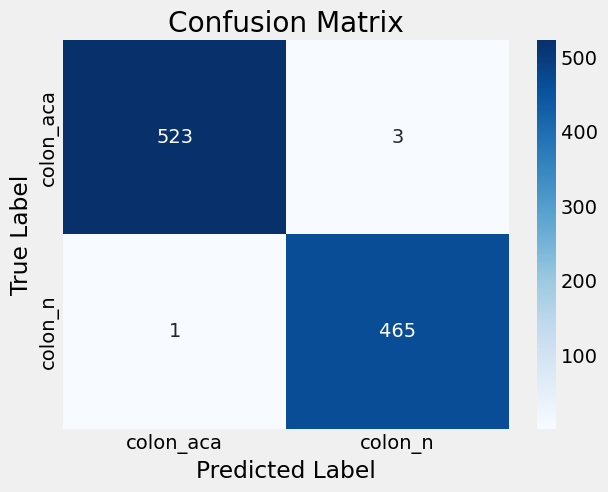

1/1 [==============================] - 0s 35ms/step
32
1/1 [==============================] - 0s 27ms/step
64
1/1 [==============================] - 0s 26ms/step
96
1/1 [==============================] - 0s 33ms/step
128
1/1 [==============================] - 0s 24ms/step
160
1/1 [==============================] - 0s 45ms/step
192
1/1 [==============================] - 0s 31ms/step
224
1/1 [==============================] - 0s 39ms/step
256
1/1 [==============================] - 0s 35ms/step
288
1/1 [==============================] - 0s 38ms/step
320
1/1 [==============================] - 0s 37ms/step
352
1/1 [==============================] - 0s 38ms/step
384
1/1 [==============================] - 0s 38ms/step
416
1/1 [==============================] - 0s 24ms/step
448
1/1 [==============================] - 0s 23ms/step
480
1/1 [==============================] - 0s 23ms/step
512
1/1 [==============================] - 0s 25ms/step
544
1/1 [==============================] - 0s 23ms/step

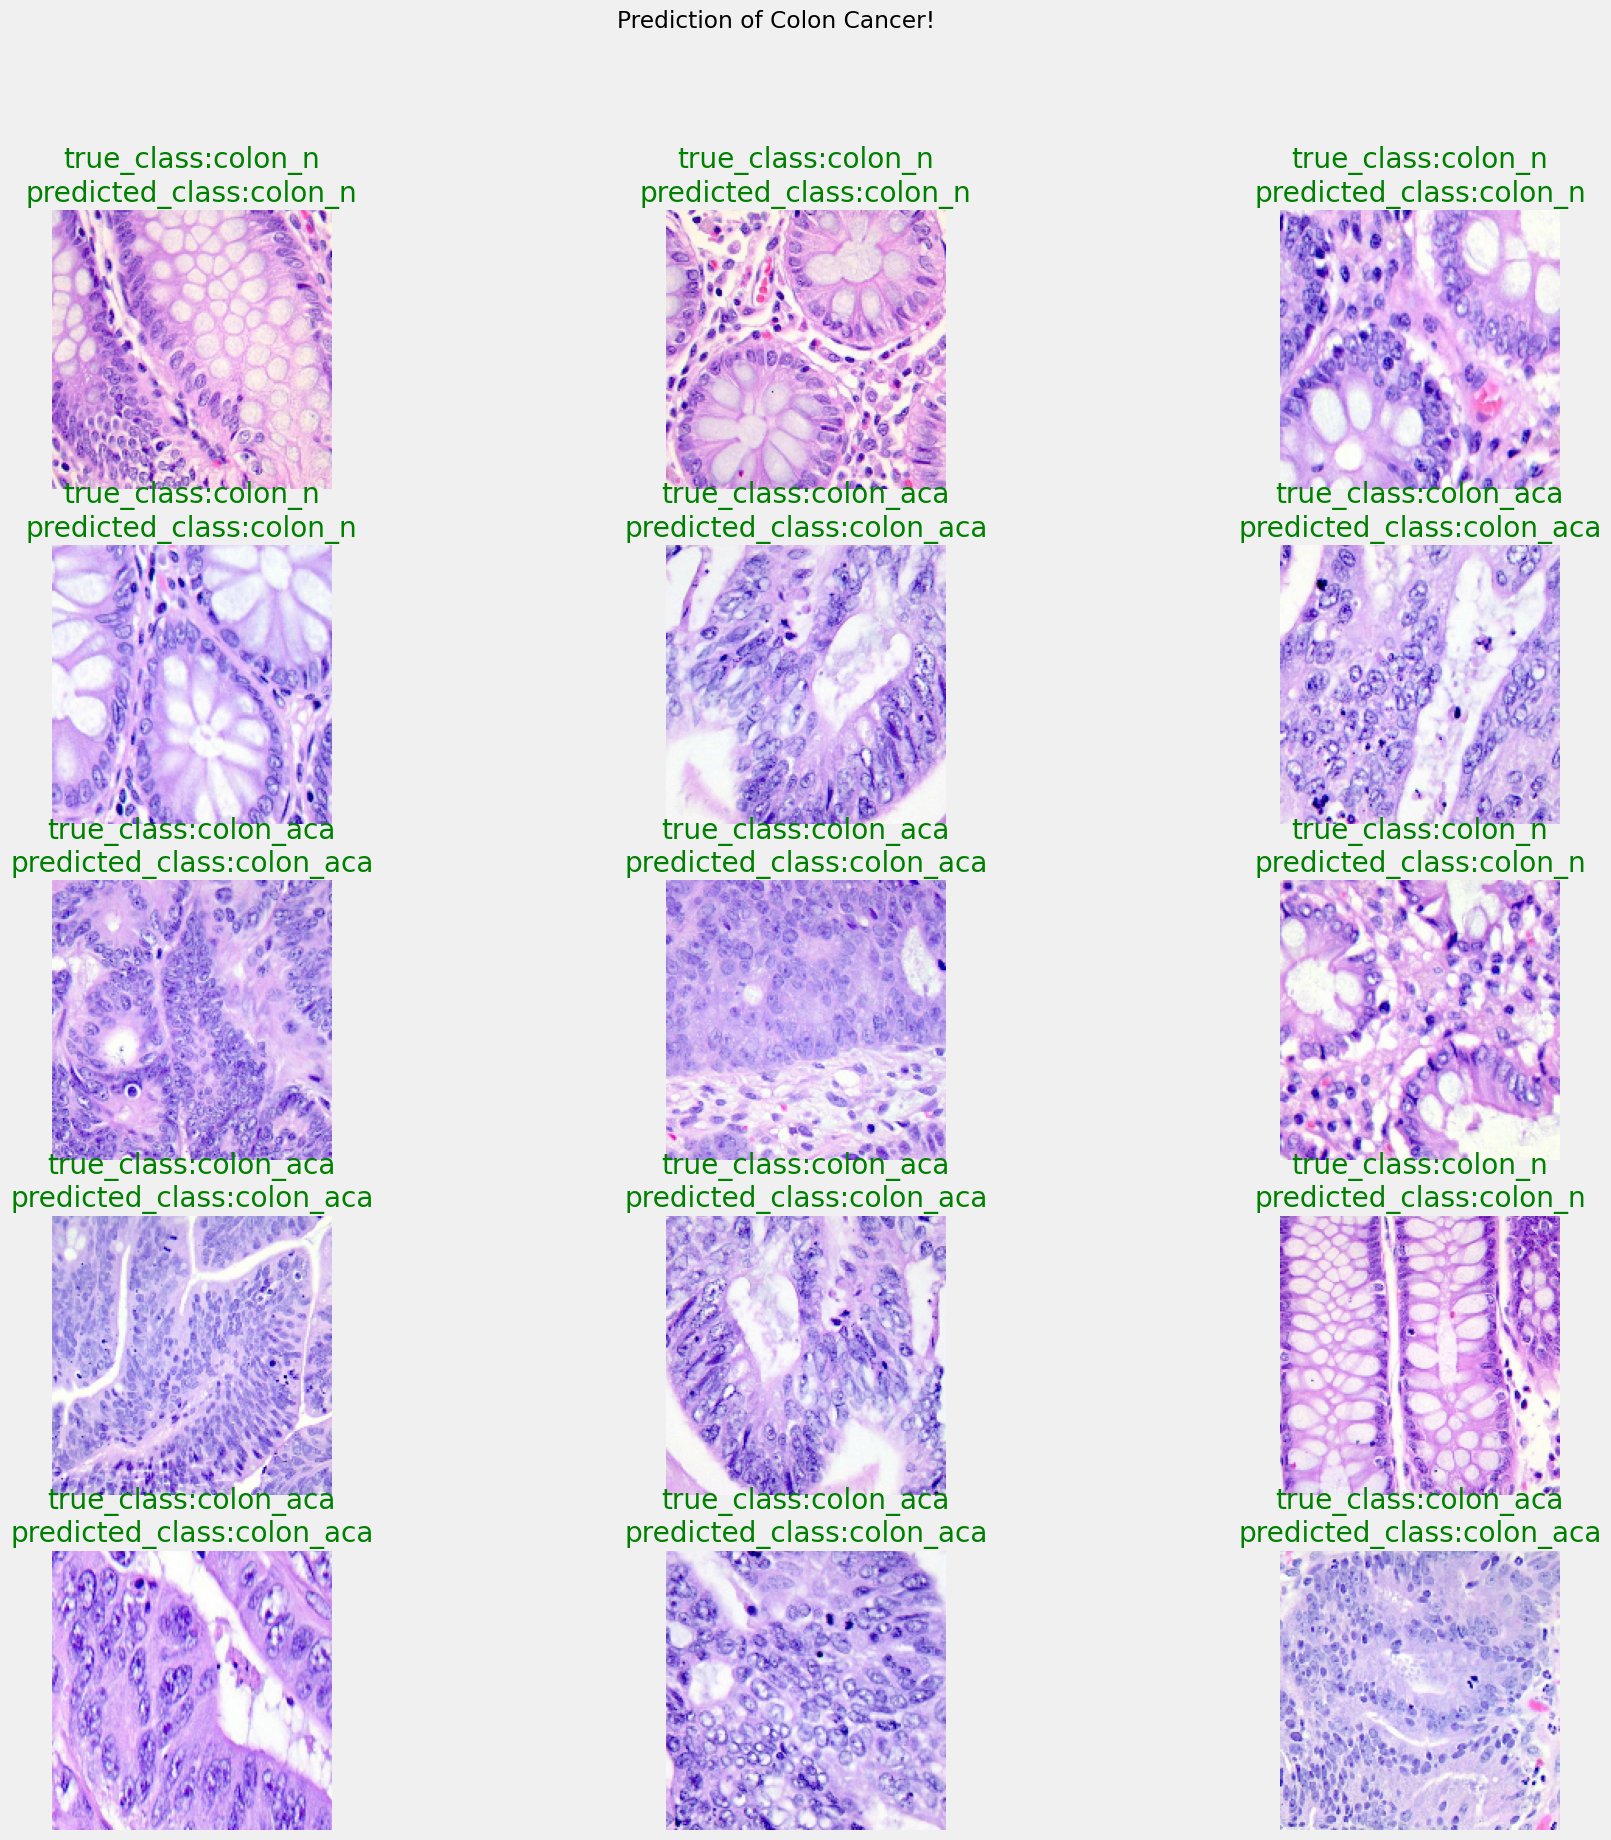

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import layers
from tensorflow.keras import callbacks
# Set Constants 

dirpath='E:/A__CVPR/Dataset/lung_colon_image_set/colon_image_sets'
IMG_SIZE=180
BATCH_SIZE=32
CHANNELS=3
EPOCHS=20
INPUT_SHAPE = (BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNELS)
N_CLASSES = 2
# classes=['Colon adenocarcinoma'
# 'Colon benign tissue']


# Import data into tensorflow dataset object

dataset= tf.keras.preprocessing.image_dataset_from_directory(
    dirpath,
    seed=123,
    shuffle=True,
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE
)
classes_name=dataset.class_names
classes_name
for batch_img,batch_label in dataset.take(1):
    print(batch_img.shape)
    print(batch_label.numpy())

# Show some samples of images!
plt.figure(figsize=(20, 20))
plt.suptitle('Samples of images!')
for batch_img,batch_label in dataset.take(1):
   for i in range(20):
      ax=plt.subplot(5,4,i+1)
      plt.title(classes_name[batch_label[i]])
      plt.imshow(batch_img[i].numpy().astype('uint8'))
      plt.axis('off')

def split_train_val_test(dataset,train_split=0.8,test_split=0.1,val_split=0.1,shuffle=True,shuffle_size=10000):
   assert(train_split+val_split+test_split)==1


   if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)
    #set size of train,test and val
   train_size=int(train_split*len(dataset))
   val_size=int(val_split*len(dataset))
   test_size=int(test_split*len(dataset))


   train_ds=dataset.take(train_size)
   val_ds=dataset.skip(train_size).take(val_size)
   test_ds=dataset.skip(train_size+val_size).take(test_size)


   return train_ds,val_ds,test_ds

train,val,test=split_train_val_test(dataset)


print(len(train))
print(len(test))
print(len(val))

# Cache, Shuffle, and Prefetch the Dataset

train_ds = train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Creating a Layer for Resizing and Normalization

resize_scaling=tf.keras.Sequential([
    layers.Resizing(IMG_SIZE,IMG_SIZE),
    layers.Rescaling(1./255)
])

 # Build The Model
cnn_model=tf.keras.models.Sequential([
    resize_scaling,
    layers.Conv2D(32, kernel_size = (3,3),padding='same',activation='relu', input_shape=INPUT_SHAPE),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), padding='same',activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(N_CLASSES,activation='softmax')

])
cnn_model.build(input_shape=INPUT_SHAPE)
cnn_model.summary()
tensorboard = tf.keras.callbacks.TensorBoard(log_dir = 'logs')
checkpoint =tf.keras.callbacks.ModelCheckpoint("colon.keras",monitor="val_loss",save_best_only=True,mode="auto",verbose=1)
reduce_lr =tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min',restore_best_weights=True)

cnn_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])


history=cnn_model.fit(train_ds,validation_data=val_ds,epochs=40,batch_size=BATCH_SIZE,verbose=1,
             callbacks=[tensorboard,checkpoint,early_stopping,reduce_lr])

cnn_model.evaluate(test_ds)


# Evaluate The Model

train_score = cnn_model.evaluate(train_ds, verbose= 1)
valid_score = cnn_model.evaluate(val_ds, verbose= 1)
test_score =cnn_model.evaluate(test_ds, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])


 # Show The Model performance!
 # Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'skyblue', label= 'Training loss')
plt.plot(Epochs, val_loss, 'purple', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'skyblue', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'purple', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()



def display_conf_matrix():
    all_true_labels = []
    all_predicted_labels = []
    classes_name=dataset.class_names
    for image_batch, label_batch in test_ds:
        # Make predictions on the batch
        predictions = cnn_model.predict(image_batch)

        # Convert predictions to class indices
        predicted_labels = np.argmax(predictions, axis=1)
        true_labels = label_batch
        # # Convert one-hot encoded true labels to class indices
        # true_labels = np.argmax(label_batch, axis=1)

        all_true_labels.extend(true_labels)
        all_predicted_labels.extend(predicted_labels)

    # Convert lists to numpy arrays
    all_true_labels = np.array(all_true_labels)
    all_predicted_labels = np.array(all_predicted_labels)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)

    print(classification_report(all_true_labels,all_predicted_labels))

    # Plot confusion matrix
    #plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d',cmap='Blues', xticklabels=classes_name, yticklabels=classes_name)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


display_conf_matrix()

#  get predictions!
def get_predicitions():
    all_true_labels = []
    all_predicted_labels = []
    all_images=[]

    classes_name=dataset.class_names
    #get all the predictions and true labels
    for image_batch, label_batch in test_ds:
            # Make predictions on the batch
            predictions = cnn_model.predict(image_batch)

            # Convert predictions to class indices
            predicted_labels = np.argmax(predictions, axis=1)

            #append matrix of images
            all_images.extend(image_batch)
            true_labels = label_batch

            all_true_labels.extend(true_labels)
            all_predicted_labels.extend(predicted_labels)

            print(len(all_true_labels))
    #plot the predictions
    index=0
    plt.figure(figsize=(20, 20))
    plt.suptitle('Prediction of Colon Cancer!')

    for i in range(30,61):
        if index<15:
            ax=plt.subplot(5,3,index+1)
            color = 'green' if all_true_labels[i] == all_predicted_labels[i] else 'red'
            plt.title(f'true_class:{classes_name[all_true_labels[i]]}\npredicted_class:{classes_name[all_predicted_labels[i]]}',color=color)
            plt.imshow(np.array(all_images[i]).astype('uint8'))
            plt.axis('off')
            index+=1
        else:
            index=0


get_predicitions()




